<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_masalah_saturasi_pada_fungsi_aktivasi_Sigmoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Studi Kasus Saturasi: Membandingkan Sigmoid vs. ReLU pada Klasifikasi**

Studi kasus ini menggunakan _dataset_ klasik **Iris** (klasifikasi multi-kelas) dan PyTorch untuk melatih dua model identik, hanya berbeda pada fungsi aktivasinya di lapisan tersembunyi.

### **1. Persiapan Lingkungan dan Data**

Langkah pertama adalah mengimpor _library_ yang diperlukan dan mengambil _dataset_ Iris yang sudah tersedia dalam _library_ `scikit-learn`.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Mengambil Dataset Iris
iris = load_iris()
X = iris.data
y = iris.target

# 2. Preprocessing Data
# Standarisasi (penting agar input tidak terlalu besar/kecil, tapi kita sengaja
# akan membuat input menjadi besar (scaling tinggi) untuk memperparah saturasi
# untuk tujuan demonstrasi Sigmoid)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Secara sengaja, kita 'memperbesar' rentang data input (misalnya dikali 50)
# Ini mensimulasikan kondisi di mana input ke layer tersembunyi menjadi sangat besar,
# yang sangat memperparah saturasi Sigmoid, namun tidak memengaruhi ReLU.
X = X * 50

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Konversi ke Tensor PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"Shape Data Input: {X_train.shape}")
print(f"Shape Target Output: {y_train.shape}")

Shape Data Input: torch.Size([120, 4])
Shape Target Output: torch.Size([120])


### **2. Definisi Model Jaringan Saraf Tiruan (JST)**

Kita akan mendefinisikan sebuah kelas JST yang mengambil fungsi aktivasi sebagai parameter, sehingga kita bisa dengan mudah membuat model Sigmoid dan model ReLU.

In [3]:
class SimpleClassifier(nn.Module):
    def __init__(self, activation_fn):
        super(SimpleClassifier, self).__init__()
        self.layer_1 = nn.Linear(4, 50)  # 4 fitur input, 50 neuron tersembunyi
        self.activation = activation_fn
        self.layer_2 = nn.Linear(50, 3)  # 50 neuron tersembunyi, 3 kelas output

    def forward(self, x):
        # Aktivasi diterapkan pada lapisan tersembunyi
        x = self.layer_1(x)
        x = self.activation(x)
        x = self.layer_2(x)
        return x

# Inisialisasi Fungsi Aktivasi
sigmoid = nn.Sigmoid()
relu = nn.ReLU()

# Definisikan Kedua Model
model_sigmoid = SimpleClassifier(sigmoid)
model_relu = SimpleClassifier(relu)

### **3. Pelatihan dan Pengujian Performa**

Kita akan melatih kedua model dengan kondisi yang identik (kecuali fungsi aktivasi) dan mencatat _Loss_ pada setiap _epoch_ untuk visualisasi konvergensi.

In [4]:
def train_model(model, X_train, y_train, epochs=200):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return loss_history

# Latih Kedua Model
epochs = 100
loss_sigmoid = train_model(model_sigmoid, X_train, y_train, epochs=epochs)
loss_relu = train_model(model_relu, X_train, y_train, epochs=epochs)

print("Pelatihan Model Sigmoid Selesai.")
print("Pelatihan Model ReLU Selesai.")

Pelatihan Model Sigmoid Selesai.
Pelatihan Model ReLU Selesai.


### **4. Visualisasi Saturasi (Vanishing Gradient)**

Tahap terpenting adalah memvisualisasikan kurva _Loss_ kedua model. Kurva _Loss_ model Sigmoid akan menunjukkan laju penurunan yang jauh lebih lambat (atau bahkan stagnan) karena masalah saturasi.

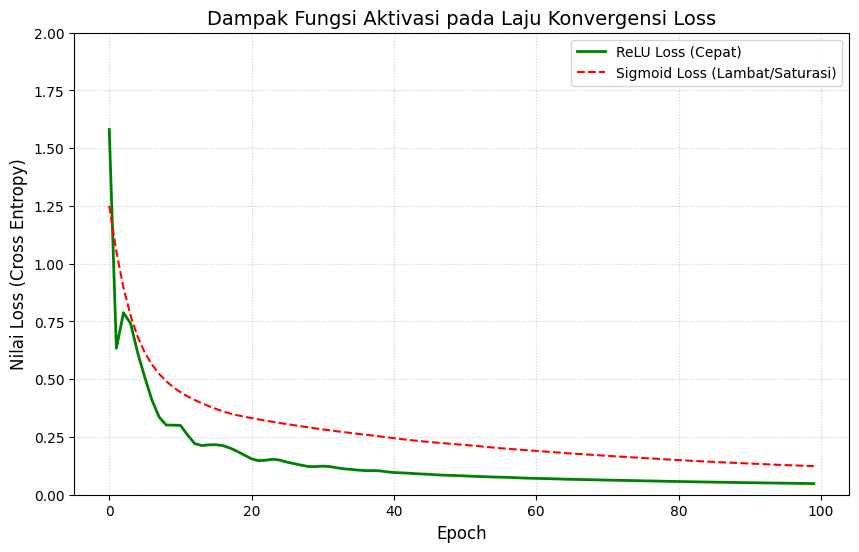


--- Analisis Konvergensi ---
Loss Akhir (Sigmoid): 0.1237
Loss Akhir (ReLU): 0.0482


In [5]:
# Visualisasi Kurva Loss
plt.figure(figsize=(10, 6))
plt.plot(loss_relu, label='ReLU Loss (Cepat)', color='green', linewidth=2)
plt.plot(loss_sigmoid, label='Sigmoid Loss (Lambat/Saturasi)', color='red', linestyle='--')

plt.title('Dampak Fungsi Aktivasi pada Laju Konvergensi Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Nilai Loss (Cross Entropy)', fontsize=12)
plt.ylim(0, 2) # Sesuaikan batas Y
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# Kesimpulan Hasil
print("\n--- Analisis Konvergensi ---")
print(f"Loss Akhir (Sigmoid): {loss_sigmoid[-1]:.4f}")
print(f"Loss Akhir (ReLU): {loss_relu[-1]:.4f}")

Mahasiswa, amati grafik di atas!

-   **Kurva Hijau (ReLU):** Penurunan _Loss_ terjadi dengan cepat dan drastis. Ini karena gradiennya (turunan) di bagian positif konstan **1**. Neuron-neuron tidak pernah "lelah" dan selalu memberikan sinyal balik yang kuat saat _backpropagation_.
    
-   **Kurva Merah (Sigmoid):** Penurunan _Loss_ terlihat sangat lambat atau hampir datar sejak awal. Ini adalah bukti visual dari masalah **Vanishing Gradient** atau **Saturasi**. Karena kita sengaja membuat input besar, nilai  berada di ekor Sigmoid di mana gradiennya mendekati **nol**. Alhasil, bobot  model Sigmoid hampir tidak diperbarui, dan pembelajaran menjadi stagnan.
    

**Inilah mengapa ReLU menjadi standar industri:** Ia secara fundamental mengatasi hambatan matematis yang membuat jaringan dalam sulit dilatih di era Sigmoid.